In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from ema_workbench import (Model, RealParameter, ScalarOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim, dimensional_stacking

In [11]:
experiments, outcomes = load_results('./data/exploratory_results_40000_zero_policy.tar.gz')

In [15]:
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

In [17]:
results = pd.concat([experiments, outcomes], axis = 1)

In [19]:
uncertainties = experiments.iloc[:, :19]
levers = experiments.iloc[:, 19:50]

In [27]:
X = uncertainties
y = outcomes['Expected Number of Deaths']

In [29]:
a = y.quantile(0.85)
Y = (y > a).astype(int).values

In [31]:
ema_logging.log_to_stderr(ema_logging.INFO)

prim_algorithm = prim.Prim(X, Y, threshold = 0.75)
box1 = prim_algorithm.find_box()

[MainProcess/INFO] 40000 points remaining, containing 6000 cases of interest
C:\Users\maxva\anaconda3\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.08085, coverage: 0.539, density: 1.0 restricted_dimensions: 4


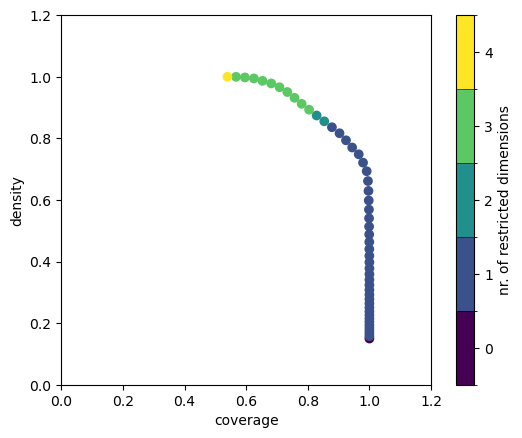

In [33]:
box1.show_tradeoff()
plt.show()

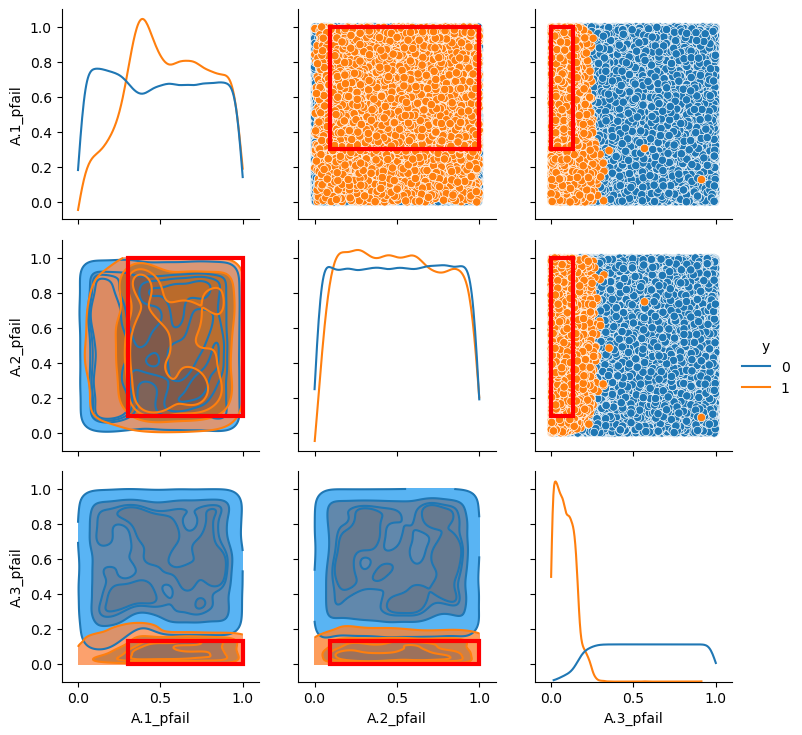

In [41]:
box1.show_pairs_scatter()
plt.show()

In [35]:
scenarios_of_interest = box1.peeling_trajectory
scenarios_of_interest = scenarios_of_interest[
    (scenarios_of_interest.coverage > 0.6) & 
    (scenarios_of_interest.coverage < 0.9) & 
    (scenarios_of_interest.density > 0.8)
]

The main focus of the client is to prevent casualties. Therefore it is important to have a high coverage as you don't want to miss scenario's with a high expected amount of casualties. It is less precise but more certain that all high casualty scenario's are captured in the box. Coverage above 0.9, therefore we loosen density restrictions to 0.5.

In [37]:
scenarios_of_interest = scenarios_of_interest.sort_values(by='density', ascending=False)
scenarios_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
46,0.625000,0.994431,46,3750,0.094275,0.994431,3771,3
45,0.652833,0.986650,45,3917,0.099250,0.986650,3970,3
44,0.681333,0.978224,44,4088,0.104475,0.978224,4179,3
43,0.708167,0.965901,43,4249,0.109975,0.965901,4399,3
42,0.733500,0.950335,42,4401,0.115775,0.950335,4631,3
41,0.756833,0.931487,41,4541,0.121875,0.931487,4875,3
40,0.780000,0.911925,40,4680,0.128300,0.911925,5132,3
39,0.804167,0.893022,39,4825,0.135075,0.893022,5403,3
38,0.828667,0.874121,38,4972,0.142200,0.874121,5688,2
37,0.853500,0.855210,37,5121,0.149700,0.855210,5988,2


In [39]:
chosen_box = scenarios_of_interest[scenarios_of_interest['id'] == 41]
chosen_box_id = 41

In [41]:
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.000888,"{1.0, 10.0, 1.5}",0.190545,30.007855,"{1.5, 10.0, 1.0}",0.046836,30.000661,"{1.5, 10.0, 1.0}",0.000020,30.001156,"{1.0, 10.0, 1.5}",0.000015,30.007770,"{1.0, 10.0, 1.5}",0.000017,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.999971,"{1.0, 10.0, 1.5}",0.999982,349.997165,"{1.5, 10.0, 1.0}",0.999981,349.994008,"{1.5, 10.0, 1.0}",0.157599,349.997570,"{1.0, 10.0, 1.5}",0.999996,349.999333,"{1.0, 10.0, 1.5}",0.999977,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [43]:
results_PRIM = results[
    (results['A.1_pfail'] >= limits['A.1_pfail'][0]) & (results['A.1_pfail'] <= limits['A.1_pfail'][1]) &
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

In [45]:
results_PRIM = results_PRIM.drop(columns=['policy', 'model'])
#results_box_numeric.to_csv('./data/prim_results_box.csv')

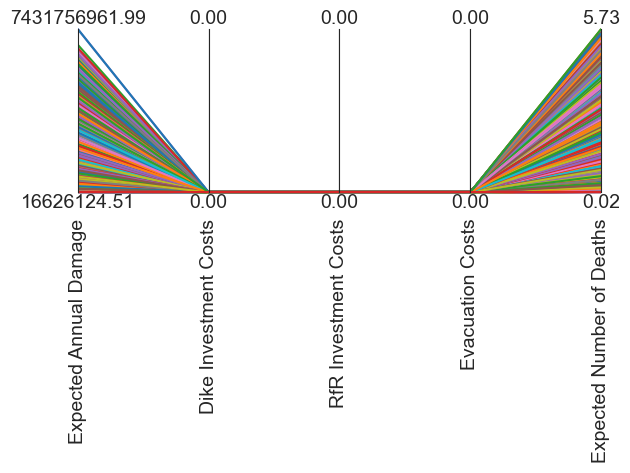

In [47]:
from ema_workbench.analysis import parcoords

data = pd.DataFrame({k:v for k,v in outcomes.items()})

indices = pd.concat([data.idxmax(), data.idxmin()]).unique()

limits = parcoords.get_limits(data)
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
axes.plot(data.iloc[indices, :])
fig = plt.gcf()

plt.show()

In [49]:
print(data.idxmax())
print(data.idxmin())

Expected Annual Damage       30634
Dike Investment Costs            0
RfR Investment Costs             0
Evacuation Costs                 0
Expected Number of Deaths    11898
dtype: int64
Expected Annual Damage       38351
Dike Investment Costs            0
RfR Investment Costs             0
Evacuation Costs                 0
Expected Number of Deaths    38351
dtype: int64


In [51]:
selected_scenarios = experiments.loc[[30634, 11898, 38351]]
selected_scenarios = selected_scenarios.drop(columns=['policy', 'model'])

In [53]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario
30634,33,312.079524,1.5,0.312473,284.295637,10.0,0.049887,188.118806,10.0,0.001112,...,0,0,0,0,0,0,0,0,0,30634
11898,26,51.948864,1.0,0.036014,160.576173,1.0,0.484981,58.993231,1.0,0.014595,...,0,0,0,0,0,0,0,0,0,11898
38351,12,322.195100,1.0,0.840791,310.931131,1.5,0.915714,333.259713,1.0,0.995809,...,0,0,0,0,0,0,0,0,0,38351


In [55]:
selected_scenarios = selected_scenarios.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

In [57]:
selected_scenarios.to_csv('./data/Selected_Scenarios.csv', index=False)